In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter


!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c astra-toolbox astra-toolbox --yes
import astra
from PIL import Image
import random
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


<ipython-input-2-75798648aa89>:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


✨🍰✨ Everything looks OK!
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.



In [ ]:
random.seed(1)

MR-FBP Implementation by Daniel M. Pelt

In [ ]:
#-----------------------------------------------------------------------
#Copyright 2015 Daniel M. Pelt
#
#Contact: D.M.Pelt@cwi.nl
#Website: http://www.dmpelt.com
#
#
#This file is part of the PyMR-FBP, a Python implementation of the
#MR-FBP tomographic reconstruction method.
#
#PyMR-FBP is free software: you can redistribute it and/or modify
#it under the terms of the GNU General Public License as published by
#the Free Software Foundation, either version 3 of the License, or
#(at your option) any later version.
#
#PyMR-FBP is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with PyMR-FBP. If not, see <http://www.gnu.org/licenses/>.
#
#-----------------------------------------------------------------------
import astra
import numpy as np
from six.moves import range
from scipy.signal import fftconvolve
import scipy.ndimage.filters as snf
import scipy.io as sio
import numpy.linalg as na

import os, errno

try:
    from pywt import wavedec2
except:
    astra.log.warn("No pywavelets installed, wavelet functions will not work.")

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


class plugin(astra.plugin.ReconstructionAlgorithm2D):
    """Reconstructs using the MR-FBP method [1].

    Options:

    'save_filter' (optional): file to save filter to (overwrites existing)
    'use_saved_filter' (optional): file to load filter from
    'reg_grad' (optional): amount of l2 gradient minimization
    'reg_path' (optional): folder to save range of 'reg_grad' values to
    'reg_range' (optional): range of 'reg_grad' values to try (of form (min, max, number of trials))
    'reg_wav' (optional): amount of l2 wavelet minimization
    'wav_bas' (optional): wavelet to use (see pywt.wavelist())
    'nlinear' (optional): number of linear steps in exponential binning

    [1] Pelt, D. M., & Batenburg, K. J. (2014). Improving filtered backprojection
        reconstruction by data-dependent filtering. Image Processing, IEEE
        Transactions on, 23(11), 4750-4762.
    """

    astra_name="MR-FBP"

    def customFBP(self, f, s):
        sf = np.zeros_like(s)
        padded = np.zeros(s.shape[1]*2)
        l = int(s.shape[1]/2.)
        r = l+s.shape[1]
        bl = f.shape[0]/len(s)
        for i in range(sf.shape[0]):
            padded[l:r] = s[i]
            padded[:l] = padded[l]
            padded[r:] = padded[r-1]
            sf[i] = fftconvolve(padded,f,'same')[l:r]
        return (self.W.T*sf).reshape(self.v.shape)

    def initialize(self, cfg, nlinear=2, reg_wav=None, wav_bas='haar', reg_grad=None, save_filter=None, use_saved_filter=None, reg_path=None, reg_range=(1,100,10)):
        self.W = astra.OpTomo(cfg['ProjectorId'])
        self.reg_gr = reg_grad
        self.reg_wav = reg_wav
        self.save_filter=save_filter
        self.use_saved=use_saved_filter
        self.reg_path = reg_path
        self.reg_range = reg_range
        self.wav_bas = wav_bas

        if not self.use_saved:
            self.bck = (self.W.T*np.ones_like(self.s)<self.s.shape[0]-0.5).reshape(self.v.shape)

        if self.reg_path:
            self.reg_gr=1.

        fs = self.s.shape[1]
        if fs%2==0:
            fs += 1
        mf = int(fs/2)

        w=1
        c=mf

        bas = np.zeros(fs,dtype=np.float32)
        self.basis = []
        count=0
        while c<fs:
            bas[:]=0
            l = c
            r = c+w
            if r>fs: r=fs
            bas[l:r]=1
            if l!=0:
                l = fs-c-w
                r = l+w
                if l<0: l=0
                bas[l:r]=1
            self.basis.append(bas.copy())
            c += w
            count += 1
            if count>nlinear:
                w=2*w
        self.nf = len(self.basis)

    def run(self, iterations):
        if self.use_saved:
            flt = sio.loadmat(self.use_saved)['mrfbp_flt'].flatten()
            self.v[:] = self.customFBP(flt, self.s)
            return
        nrows = self.s.size
        ncols = self.nf
        if self.reg_gr:
            nrows += 2*self.v.size
        if self.reg_wav:
            q = wavedec2(self.v,self.wav_bas)
            l = [q[0].flatten()]
            for z in range(1,len(q)):
                l.extend([y.flatten() for y in q[z]])
            l = np.hstack(l)
            nrows += l.size
        A = np.zeros((nrows,ncols),dtype=np.float32)
        astra.log.info("Generating MR-FBP matrix")
        for i, bas in enumerate(self.basis):
            astra.log.info('{:.2f} % done'.format(100*float(i)/self.nf))
            img = self.customFBP(bas, self.s)
            if self.reg_wav:
                q = wavedec2(img,self.wav_bas)
                l = [q[0].flatten()]
                for z in range(1,len(q)):
                    l.extend([y.flatten() for y in q[z]])
                l = np.hstack(l)
                A[nrows-l.size:,i] = self.reg_wav*l
            if self.reg_gr!=None:
                dx = np.zeros_like(self.v)
                dx[:-1,:] = img[:-1,:] - img[1:,:]
                dy = np.zeros_like(self.v)
                dx[:,:-1] = img[:,:-1] - img[:,1:]
                dx[self.bck]=0
                dy[self.bck]=0
                img[self.bck]=0
                A[0:self.s.size,i] = self.W*img
                A[self.s.size+0*self.v.size:self.s.size+1*self.v.size,i] = self.reg_gr*dx.flatten()
                A[self.s.size+1*self.v.size:self.s.size+2*self.v.size,i] = self.reg_gr*dy.flatten()
            else:
                img[self.bck]=0
                astra.extrautils.clipCircle(img)
                A[:self.s.size,i] = self.W*img
        b = np.zeros(nrows,dtype=np.float32)
        b[:self.s.size] = self.s.flatten()
        if self.reg_path:
            import tifffile
            mkdir_p(self.reg_path)
            l, r, s = self.reg_range
            astra.log.info("Generating regularized images")
            for i, reg in enumerate(np.linspace(l,r,s)):
                astra.log.info('{:.2f} % done'.format(100*float(i)/s))
                A[self.s.size:nrows-self.v.size,:] *= reg
                out = na.lstsq(A,b)
                flt = np.zeros_like(self.basis[0])
                for i, bas in enumerate(self.basis):
                    flt += out[0][i]*bas
                rc = self.customFBP(flt, self.s)
                tifffile.imsave(self.reg_path + os.sep + str(reg) + '.tiff', rc)
                A[self.s.size:nrows-self.v.size,:] /= reg
            return
        else:
            out = na.lstsq(A,b)
        bl = self.basis[0].shape[0]
        flt = np.zeros_like(self.basis[0])
        for i, bas in enumerate(self.basis):
            flt += out[0][i]*bas
        if self.save_filter:
            sio.savemat(self.save_filter, {'mrfbp_flt':flt}, do_compression=True, appendmat=False)
        astra.log.info("Done!")
        rc = self.customFBP(flt, self.s)
        self.v[:] = rc

In [ ]:
 astra.plugin.register(plugin)

**Phantom Generators** - 4 different types: grayscale, brain-like, binary, continuous blurry phantoms

In [ ]:
#function to generate a grayscale phantom consisted by geometrical shapes (two triangles, one circle, one bar)
def grayscale_phantom(size=256, x1_margin=50, y1_margin=10, x2_margin=50, y2_margin=50, radius=30, cx=70, x3_margin=20, y3_margin=40, tone1=0.8,
                               tone2=0.7, tone3=0.6, tone4=0.4):

  # Set up the phantom dimensions
  center = size / 2


  # Create the phantom
  phantom = np.zeros((size, size))

  # Add different structures with different grayscale values

  x1 = center - x1_margin
  y1 = center - y1_margin
  x2 = center + x1_margin
  y2 = center + y1_margin
  for x in range(size):
      for y in range(size):
          if x1 <= x <= x2 and abs(y - center) <= abs((y2 - y1) / (x2 - x1)) * abs(x - center):
              phantom[x, y] = tone1


  x1 = center - x2_margin
  y1 = center - y2_margin
  x2 = center + x2_margin
  y2 = center + y2_margin
  for x in range(size):
      for y in range(size):
          if x1 <= x <= x2 and abs(y - center) <= abs((y2 - y1) / (x2 - x1)) * abs(x - center):
              phantom[x, y] = tone2


  cx = center - cx
  cy = center
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2 + (y - cy) ** 2) <= radius ** 2:
              phantom[x, y] = tone3


  x1 = center - x3_margin
  y1 = center + y3_margin
  x2 = center + x3_margin
  y2 = center - y3_margin
  for x in range(size):
      for y in range(size):
          if abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2) <= 5:
              phantom[x, y] = tone4



  return phantom

In [ ]:
#function to generate brain-like phantom
def brain_phantom(size=256, radius1=70, tone1=0.6, radius2=20, cx1=50, tone2=0.4, cx2=50, tone3=0.4, a1 = 40, b1 = 20, cy1=20, tone4=0.5, cy2=25, tone5=0.5,
                   a2 = 35,  b2 = 15, a3 = 30, b3 = 10, cy3=50, tone6=0.5, mean=0, sd=0.05 ):
  # Set up the phantom dimensions
  center = size / 2

  # Create the phantom
  phantom = np.zeros((size, size))

  # Add different structures with different grayscale values

  # Large circle
  cx = center
  cy = center
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2 + (y - cy) ** 2) <= radius1 ** 2:
              phantom[x, y] = tone1

  # Small circles
  cx = center - cx1
  cy = center
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2 + (y - cy) ** 2) <= radius2 ** 2:
              phantom[x, y] = tone2

  cx = center + cx2
  cy = center
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2 + (y - cy) ** 2) <= radius2 ** 2:
              phantom[x, y] = tone3

  # Ellipses
  cx = center
  cy = center - cy1
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2) / (a1 ** 2) + ((y - cy) ** 2) / (b1 ** 2) <= 1:
              phantom[x, y] = tone4

  cx = center
  cy = center + cy2
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2) / (a2 ** 2) + ((y - cy) ** 2) / (b2 ** 2) <= 1:
              phantom[x, y] = tone5

  cx = center
  cy = center + cy3
  for x in range(size):
      for y in range(size):
          if ((x - cx) ** 2) / (a3 ** 2) + ((y - cy) ** 2) / (b3 ** 2) <= 1:
              phantom[x, y] = tone6

  # Add noise
  noise = np.random.normal(mean, sd, size=(size, size))
  phantom += noise


  return phantom

In [ ]:
#create binary phantom
def binary_phantom(n=256, r = 0.3, c=0.3):
  # Create grid

  x = np.linspace(-1, 1, n)
  X, Y = np.meshgrid(x, x)

  # Create binary phantom
  phantom = np.zeros((n, n))

  # Add circles

  circle1 = (X - c) ** 2 + (Y - c) ** 2 < r ** 2
  circle2 = (X + c) ** 2 + (Y - c) ** 2 < r ** 2
  circle3 = (X - c) ** 2 + (Y + c) ** 2 < r ** 2
  circle4 = (X + c) ** 2 + (Y + c) ** 2 < r ** 2
  phantom[circle1 | circle2 | circle3 | circle4] = 1

  # Add rectangles
  rect1 = (X > 0.4) & (X < 0.6) & (Y > -0.4) & (Y < 0.4)
  rect2 = (X > -0.6) & (X < -0.4) & (Y > -0.4) & (Y < 0.4)
  phantom[rect1 | rect2] = 1


  return phantom

In [ ]:
#create blurry phantoms
def blurry_phantom(N = 256, a=1, sigma=2):
  # Define grid size

  x = np.linspace(-5, 5, N)
  y = np.linspace(-5, 5, N)
  X, Y = np.meshgrid(x, y)

  # Create phantom
  phantom = np.zeros((N, N))

  # Define shapes and values
  circle1 = ((X - a)**2 + (Y - a)**2) < 1
  circle2 = ((X + a)**2 + (Y + a)**2) < 1
  square = (abs(X) < 1) & (abs(Y) < 1)
  ellipse = ((X/2)**2 + Y**2) < 1
  blurred_shape = gaussian_filter(circle1, sigma) + gaussian_filter(square, sigma)

  values = [0.3, 0.5, 0.7, 0.9, 1]

  # Create phantom with overlapping shapes and values
  for i in range(len(values)):
      if i == 0:
          phantom += values[i] * circle1
      elif i == 1:
          phantom += values[i] * square
      elif i == 2:
          phantom += values[i] * ellipse
      elif i == 3:
          phantom += values[i] * circle2
      else:
          phantom += values[i] * blurred_shape

  return phantom

**SINOGRAM AND RECONSTRUCTION**

In [ ]:
def reconstruction(phantom, angles_start=0, angles_end=np.pi, n_proj=32, size=256, noise=True):

  # Create ASTRA geometries
  vol_geom = astra.create_vol_geom(size,size)
  proj_geom = astra.create_proj_geom('parallel',1.0,size,np.linspace(angles_start, angles_end, n_proj, False))


  # Create the ASTRA projector (change 'linear' to 'cuda' to use GPU)
  pid = astra.create_projector('linear', proj_geom, vol_geom)
  p = astra.OpTomo(pid)

  # Calculate the forward projection of the phantom
  testSino = (p*phantom).reshape(p.sshape)

  # Add some noise to the sinogram
  if noise == True:
    testSino = astra.add_noise_to_sino(testSino,10**4)

  # Reconstruct the image using MR-FBP, FBP, and SIRT.
  fbpRec = p.reconstruct('FBP_CUDA',testSino,200)
  sirtRec = p.reconstruct('SIRT_CUDA',testSino,200)
  sartRec = p.reconstruct('SART_CUDA',testSino,200)
  artRec = p.reconstruct('ART',testSino,200)
  cglsRec = p.reconstruct('CGLS_CUDA',testSino,200)
  mrfbpRec = p.reconstruct('MR-FBP',testSino,200)




  # Create a 4x2 grid of subplots using GridSpec
  grid = gridspec.GridSpec(2, 3,  hspace=0.2, wspace=0.05)

  # Specify the content for each subplot
  subplot1 = plt.subplot(grid[0, 0])
  subplot1.imshow(phantom, cmap='gray')
  plt.axis('off')
  subplot1.set_title('phantom')

  subplot2 = plt.subplot(grid[0, 1])
  subplot2.imshow(mrfbpRec, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot2.set_title('mrfbpRec')

  subplot3 = plt.subplot(grid[0, 2])
  subplot3.imshow(fbpRec, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot3.set_title('fbpRec')

  subplot4 = plt.subplot(grid[1, 0])
  subplot4.imshow(sirtRec, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot4.set_title('sirtRec')

  subplot5 = plt.subplot(grid[1, 1])
  subplot5.imshow(sartRec, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot5.set_title('sartRec')

  subplot6 = plt.subplot(grid[1, 2])
  subplot6.imshow(cglsRec, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot6.set_title('cglsRec')


  # Adjust spacing between subplots if needed
  plt.tight_layout()

  # Show the plot
  plt.show()

  print(f"Mean absolute pixel error MR-FBP: {np.abs(phantom - mrfbpRec).mean():.3f}")
  print(f"Mean absolute pixel error FBP: {np.abs(phantom - fbpRec).mean():.3f}")
  print(f"Mean absolute pixel error SIRT: {np.abs(phantom - sirtRec).mean():.3f}")
  print(f"Mean absolute pixel error SART: {np.abs(phantom - sartRec).mean():.3f}")
  print(f"Mean absolute pixel error CGLS: {np.abs(phantom - cglsRec).mean():.3f}")

  return testSino


In [ ]:
def MRFBPreconstruction(phantom1, phantom2, phantom3,phantom4, angles_start=0, angles_end=np.pi, n_proj=32, size=256, noise=True):

  # Create ASTRA geometries
  vol_geom = astra.create_vol_geom(size,size)
  proj_geom = astra.create_proj_geom('parallel',1.0,size,np.linspace(angles_start, angles_end, n_proj, False))


  # Create the ASTRA projector (change 'linear' to 'cuda' to use GPU)
  pid = astra.create_projector('linear', proj_geom, vol_geom)
  p = astra.OpTomo(pid)

  # Calculate the forward projection of the phantom
  testSino1 = (p*phantom1).reshape(p.sshape)
  testSino2 = (p*phantom2).reshape(p.sshape)
  testSino3 = (p*phantom3).reshape(p.sshape)
  testSino4 = (p*phantom4).reshape(p.sshape)

  # Add some noise to the sinogram
  if noise == True:
    testSino1 = astra.add_noise_to_sino(testSino1,10**4)
    testSino2 = astra.add_noise_to_sino(testSino2,10**4)
    testSino3 = astra.add_noise_to_sino(testSino3,10**4)
    testSino4 = astra.add_noise_to_sino(testSino4,10**4)

  # Reconstruct the image using MR-FBP
  mrfbpRec1 = p.reconstruct('MR-FBP',testSino1,200)
  mrfbpRec2 = p.reconstruct('MR-FBP',testSino2,200)
  mrfbpRec3 = p.reconstruct('MR-FBP',testSino3,200)
  mrfbpRec4 = p.reconstruct('MR-FBP',testSino4,200)


  # Create a 4x2 grid of subplots using GridSpec
  grid = gridspec.GridSpec(2, 2,  hspace=0.2, wspace=0.005)

  # Specify the content for each subplot
  subplot2 = plt.subplot(grid[0, 0])
  subplot2.imshow(mrfbpRec1, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot2.set_title('Grayscale phantom')

  subplot3 = plt.subplot(grid[1, 0])
  subplot3.imshow(mrfbpRec2, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot3.set_title('Brain phantom')

  subplot4 = plt.subplot(grid[1, 1])
  subplot4.imshow(mrfbpRec3, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot4.set_title('Binary phantom')

  subplot5 = plt.subplot(grid[0, 1])
  subplot5.imshow(mrfbpRec4, cmap='gray',vmin=0,vmax=1)
  plt.axis('off')
  subplot5.set_title('Blurry&Continuous phantom')


  # Adjust spacing between subplots if needed
  plt.tight_layout()

  # Show the plot
  plt.show()

  print(f"Mean absolute pixel error Grayscale phantom: {np.abs(phantom1 - mrfbpRec1).mean():.3f}")
  print(f"Mean absolute pixel error Brain phantom: {np.abs(phantom2 - mrfbpRec2).mean():.3f}")
  print(f"Mean absolute pixel error Binary phantom: {np.abs(phantom3 - mrfbpRec3).mean():.3f}")
  print(f"Mean absolute pixel error Blurry&Continuous phantom: {np.abs(phantom4 - mrfbpRec4).mean():.3f}")


EXPERIMENT 1: Comparing MR-FBP with FBP, SIRT, SART, CGLS

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-10-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


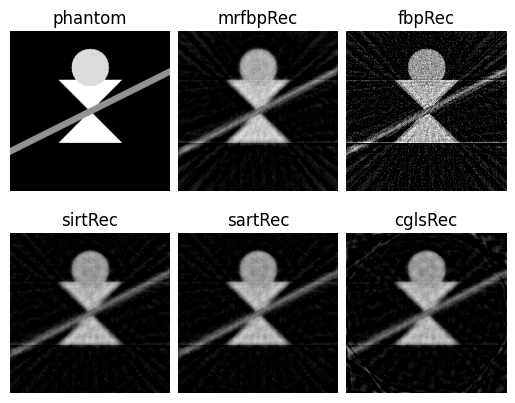

Mean absolute pixel error MR-FBP: 0.056
Mean absolute pixel error FBP: 0.140
Mean absolute pixel error SIRT: 0.049
Mean absolute pixel error SART: 0.048
Mean absolute pixel error CGLS: 0.061


In [ ]:
phantom1 = grayscale_phantom()
sino1 = reconstruction(phantom1)

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-10-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


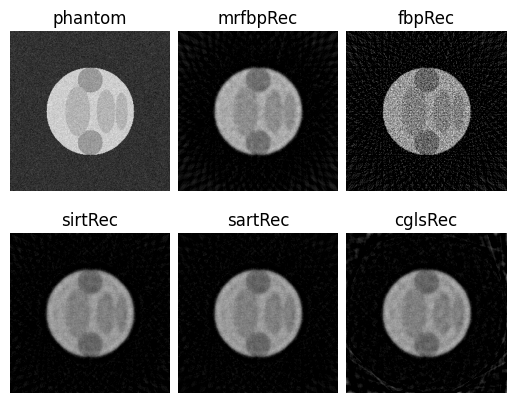

Mean absolute pixel error MR-FBP: 0.057
Mean absolute pixel error FBP: 0.119
Mean absolute pixel error SIRT: 0.050
Mean absolute pixel error SART: 0.050
Mean absolute pixel error CGLS: 0.059


In [ ]:
phantom2 = brain_phantom()
sino2 = reconstruction(phantom2)

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-10-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


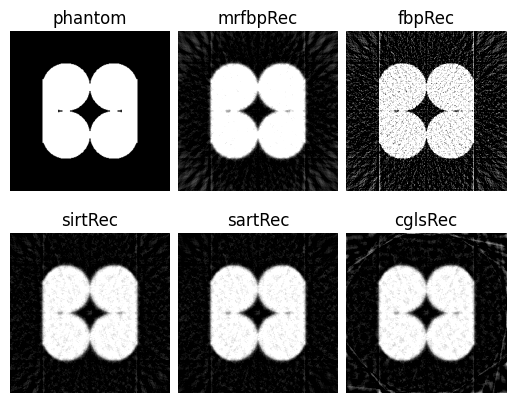

Mean absolute pixel error MR-FBP: 0.096
Mean absolute pixel error FBP: 0.240
Mean absolute pixel error SIRT: 0.074
Mean absolute pixel error SART: 0.073
Mean absolute pixel error CGLS: 0.095


In [ ]:
phantom3 = binary_phantom()
sino3 = reconstruction(phantom3)

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-10-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


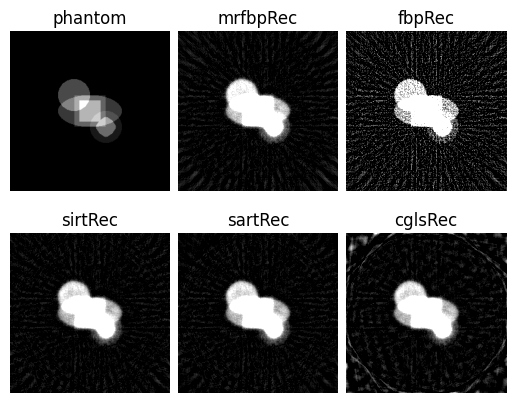

Mean absolute pixel error MR-FBP: 0.077
Mean absolute pixel error FBP: 0.237
Mean absolute pixel error SIRT: 0.070
Mean absolute pixel error SART: 0.070
Mean absolute pixel error CGLS: 0.097


In [ ]:
phantom4 = blurry_phantom()
sino4 = reconstruction(phantom4)


EXPERIMENT 2: Comparing MR-FBP method's performance on different types of phantoms: Grayscale, Brain-like, Binary, Blurry&Continuous

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-11-aaa10ffcbbcf>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


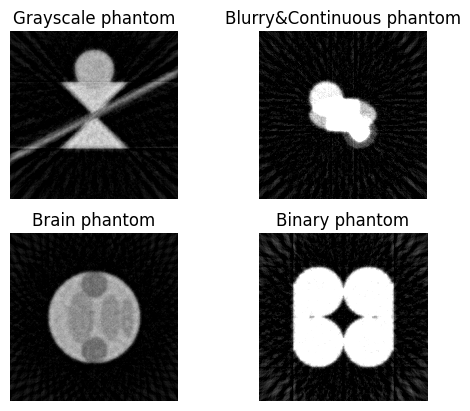

Mean absolute pixel error Grayscale phantom: 0.056
Mean absolute pixel error Brain phantom: 0.057
Mean absolute pixel error Binary phantom: 0.096
Mean absolute pixel error Blurry&Continuous phantom: 0.078


In [ ]:
MRFBPreconstruction(phantom1, phantom2, phantom3, phantom4)

EXPERIMENT 3: Angles limitation

1. Angle Range [0,pi/2]

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-11-aaa10ffcbbcf>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


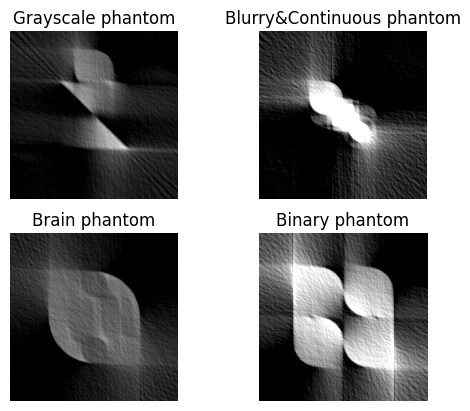

Mean absolute pixel error Grayscale phantom: 0.123
Mean absolute pixel error Brain phantom: 0.138
Mean absolute pixel error Binary phantom: 0.259
Mean absolute pixel error Blurry&Continuous phantom: 0.186


In [ ]:
MRFBPreconstruction(phantom1,phantom2,phantom3,phantom4, angles_start=0, angles_end=np.pi/2)

2. Angle Range = [0,pi/4]

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-11-aaa10ffcbbcf>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


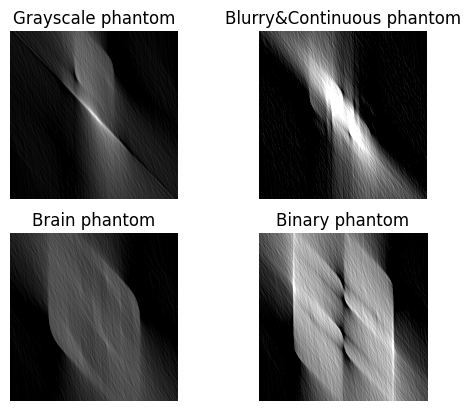

Mean absolute pixel error Grayscale phantom: 0.129
Mean absolute pixel error Brain phantom: 0.159
Mean absolute pixel error Binary phantom: 0.311
Mean absolute pixel error Blurry&Continuous phantom: 0.217


In [ ]:
MRFBPreconstruction(phantom1, phantom2, phantom3, phantom4, angles_start=0, angles_end=np.pi/4)

2. Angle Range = [0,pi/8]

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-11-aaa10ffcbbcf>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


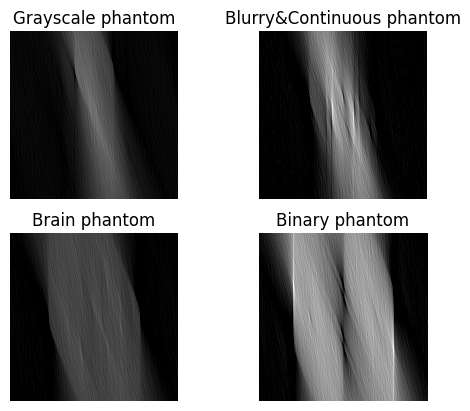

Mean absolute pixel error Grayscale phantom: 0.121
Mean absolute pixel error Brain phantom: 0.156
Mean absolute pixel error Binary phantom: 0.303
Mean absolute pixel error Blurry&Continuous phantom: 0.204


In [ ]:
MRFBPreconstruction(phantom1, phantom2, phantom3, phantom4, angles_start=0, angles_end=np.pi/8)

EXPERIMENT 4: Checking if projections from a few angles are improved without added noise on sinograms

<ipython-input-4-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-11-aaa10ffcbbcf>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


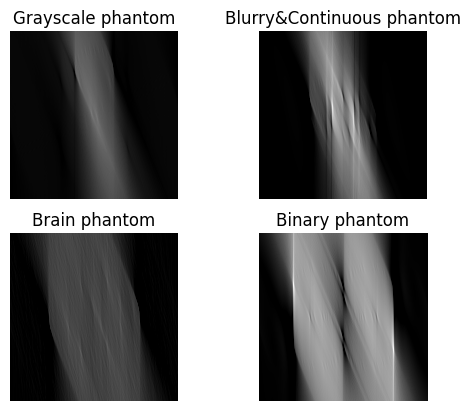

Mean absolute pixel error Grayscale phantom: 0.118
Mean absolute pixel error Brain phantom: 0.155
Mean absolute pixel error Binary phantom: 0.299
Mean absolute pixel error Blurry&Continuous phantom: 0.190


In [ ]:
# reconstruction(phantom1, angles_start=0, angles_end=np.pi/2, size=256, noise=False)
MRFBPreconstruction(phantom1, phantom2, phantom3, phantom4, angles_start=0, angles_end=np.pi/8, noise = False)

EXPERIMENT 5: Deep learning approach - CNN - encoder/decoder idea

In [ ]:
# Define the U-Net model
class UNet(nn.Module):
      def __init__(self):
          super(UNet, self).__init__()

          # Encoder
          self.encoder_conv1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
          self.encoder_relu1 = nn.ReLU()
          self.encoder_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
          self.encoder_relu2 = nn.ReLU()

          # Decoder
          self.decoder_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
          self.decoder_relu1 = nn.ReLU()
          self.decoder_conv2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
          self.decoder_relu2 = nn.ReLU()

      def forward(self, x):
          # Encoder
          enc1 = self.encoder_relu1(self.encoder_conv1(x))
          enc2 = self.encoder_relu2(self.encoder_conv2(enc1))

          # Decoder
          dec1 = self.decoder_relu1(self.decoder_conv1(enc2))
          dec2 = self.decoder_relu2(self.decoder_conv2(dec1))

          return dec2

In [ ]:
def CNNReC(phantom,sino):

  # Load your custom phantom data as NumPy arrays
  normalized_target_data = (phantom - np.min(phantom)) / (np.max(phantom) - np.min(phantom))
  normalized_input_data = (sino - np.min(sino)) / (np.max(sino) - np.min(sino))


  # Convert the phantom data to PyTorch tensor
  tensor_data = torch.from_numpy(normalized_target_data).unsqueeze(1).float()
  sino = torch.from_numpy(normalized_input_data).unsqueeze(1).float()

  # Create an instance of the reconstruction network
  net = UNet()

  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # Training loop
  num_epochs = 10000
  for epoch in range(num_epochs):

      optimizer.zero_grad()

      # Forward pass
      outputs = net(sino)

      # Compute the loss
      loss = criterion(outputs, tensor_data)

      # Backpropagation and optimization
      loss.backward()
      optimizer.step()

      # Print the loss for monitoring
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

  # Save the trained model
  torch.save({
      'model_state_dict': net.state_dict(),
  }, 'trained_model.pth')
  # Get the reconstructed images
  reconstructed_images = outputs.detach().numpy()

  # Display a reconstructed image
  plt.imshow(reconstructed_images[:, 0, :], cmap='gray')
  plt.axis('off')
  plt.show()

Implementing CNN on original phantoms with full range angles

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.016743440181016922
Epoch 5002/10000, Loss: 0.01673002913594246
Epoch 5003/10000, Loss: 0.016719413921236992
Epoch 5004/10000, Loss: 0.016697147861123085
Epoch 5005/10000, Loss: 0.016680587083101273
Epoch 5006/10000, Loss: 0.016669640317559242
Epoch 5007/10000, Loss: 0.016667375341057777
Epoch 5008/10000, Loss: 0.016676343977451324
Epoch 5009/10000, Loss: 0.01668892800807953
Epoch 5010/10000, Loss: 0.016714949160814285
Epoch 5011/10000, Loss: 0.016724303364753723
Epoch 5012/10000, Loss: 0.016752157360315323
Epoch 5013/10000, Loss: 0.016743727028369904
Epoch 5014/10000, Loss: 0.016751982271671295
Epoch 5015/10000, Loss: 0.016728566959500313
Epoch 5016/10000, Loss: 0.016717789694666862
Epoch 5017/10000, Loss: 0.016704024747014046
Epoch 5018/10000, Loss: 0.01670299842953682
Epoch 5019/10000, Loss: 0.016713563352823257
Epoch 5020/10000, Loss: 0.01672390103340149
Epoch 5021/10000, Loss: 0.016742169857025146
Epoch 50

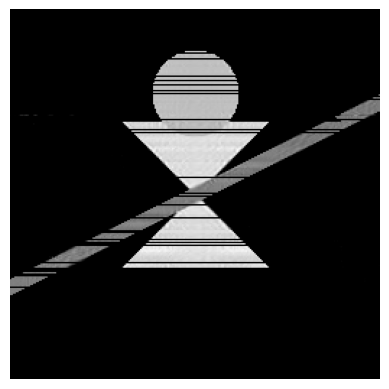

In [ ]:
CNNReC(phantom1,sino1)

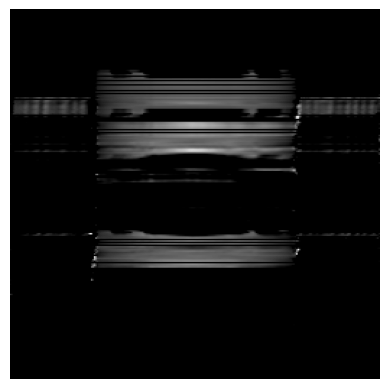

In [ ]:
# Load the pre-trained model
checkpoint = torch.load('trained_model.pth')
net = UNet()
net.load_state_dict(checkpoint['model_state_dict'])

# Load your custom phantom data as NumPy arrays
normalized_target_data = (phantom2 - np.min(phantom2)) / (np.max(phantom2) - np.min(phantom2))
normalized_input_data = (sino2 - np.min(sino2)) / (np.max(sino2) - np.min(sino2))

# Convert the phantom data to PyTorch tensor
tensor_data = torch.from_numpy(normalized_target_data).unsqueeze(1).float()
sino = torch.from_numpy(normalized_input_data).unsqueeze(1).float()

# Run the forward pass
with torch.no_grad():
    reconstructed_output = net(sino)


# Convert the reconstructed output to NumPy array
reconstructed_image = reconstructed_output.detach().numpy()

# Display the reconstructed image
plt.imshow(reconstructed_image[:, 0, :], cmap='gray')
plt.axis('off')
plt.show()

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.008223389275372028
Epoch 5002/10000, Loss: 0.008232876658439636
Epoch 5003/10000, Loss: 0.008234317414462566
Epoch 5004/10000, Loss: 0.008242733776569366
Epoch 5005/10000, Loss: 0.00823892466723919
Epoch 5006/10000, Loss: 0.00824313797056675
Epoch 5007/10000, Loss: 0.008236373774707317
Epoch 5008/10000, Loss: 0.00824001431465149
Epoch 5009/10000, Loss: 0.008234492503106594
Epoch 5010/10000, Loss: 0.008237103000283241
Epoch 5011/10000, Loss: 0.008229742757976055
Epoch 5012/10000, Loss: 0.008221081458032131
Epoch 5013/10000, Loss: 0.008207953535020351
Epoch 5014/10000, Loss: 0.008198943920433521
Epoch 5015/10000, Loss: 0.008195452392101288
Epoch 5016/10000, Loss: 0.008195324800908566
Epoch 5017/10000, Loss: 0.008200842887163162
Epoch 5018/10000, Loss: 0.008206313475966454
Epoch 5019/10000, Loss: 0.008214388974010944
Epoch 5020/10000, Loss: 0.008217236027121544
Epoch 5021/10000, Loss: 0.008220127783715725
Epoch 5

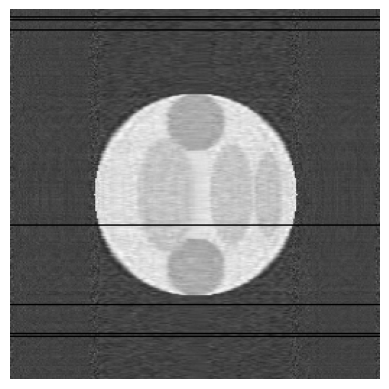

In [ ]:
CNNReC(phantom2,sino2)

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.03402005136013031
Epoch 5002/10000, Loss: 0.03401476889848709
Epoch 5003/10000, Loss: 0.034029584378004074
Epoch 5004/10000, Loss: 0.03405047208070755
Epoch 5005/10000, Loss: 0.03404868766665459
Epoch 5006/10000, Loss: 0.03404189646244049
Epoch 5007/10000, Loss: 0.034015949815511703
Epoch 5008/10000, Loss: 0.03401224687695503
Epoch 5009/10000, Loss: 0.03402402997016907
Epoch 5010/10000, Loss: 0.034032803028821945
Epoch 5011/10000, Loss: 0.03404248505830765
Epoch 5012/10000, Loss: 0.034034762531518936
Epoch 5013/10000, Loss: 0.034019459038972855
Epoch 5014/10000, Loss: 0.03401024639606476
Epoch 5015/10000, Loss: 0.03400981426239014
Epoch 5016/10000, Loss: 0.03401349484920502
Epoch 5017/10000, Loss: 0.03402116149663925
Epoch 5018/10000, Loss: 0.03403108939528465
Epoch 5019/10000, Loss: 0.034025974571704865
Epoch 5020/10000, Loss: 0.03402017056941986
Epoch 5021/10000, Loss: 0.034012630581855774
Epoch 5022/10000, 

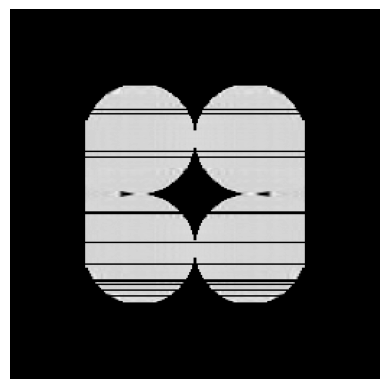

In [ ]:
CNNReC(phantom3,sino3)

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.0018111036624759436
Epoch 5002/10000, Loss: 0.0018096723360940814
Epoch 5003/10000, Loss: 0.0018089369405061007
Epoch 5004/10000, Loss: 0.0018088789656758308
Epoch 5005/10000, Loss: 0.0018091624369844794
Epoch 5006/10000, Loss: 0.0018096726853400469
Epoch 5007/10000, Loss: 0.0018107371870428324
Epoch 5008/10000, Loss: 0.0018120990134775639
Epoch 5009/10000, Loss: 0.0018136778380721807
Epoch 5010/10000, Loss: 0.0018146811053156853
Epoch 5011/10000, Loss: 0.0018155183643102646
Epoch 5012/10000, Loss: 0.0018151658587157726
Epoch 5013/10000, Loss: 0.0018141934415325522
Epoch 5014/10000, Loss: 0.001812897389754653
Epoch 5015/10000, Loss: 0.0018119530286639929
Epoch 5016/10000, Loss: 0.0018117560539394617
Epoch 5017/10000, Loss: 0.0018122941255569458
Epoch 5018/10000, Loss: 0.0018133511766791344
Epoch 5019/10000, Loss: 0.001814441755414009
Epoch 5020/10000, Loss: 0.0018169863615185022
Epoch 5021/10000, Loss: 0.00181

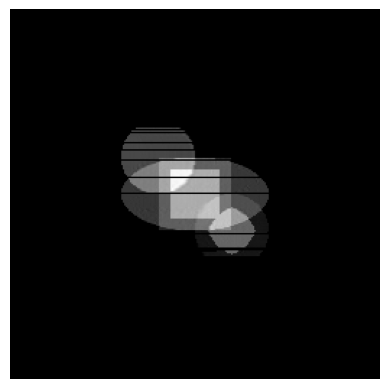

In [ ]:
CNNReC(phantom4,sino4)

Implementing CNN on phantoms with limited angles

<ipython-input-148-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-154-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


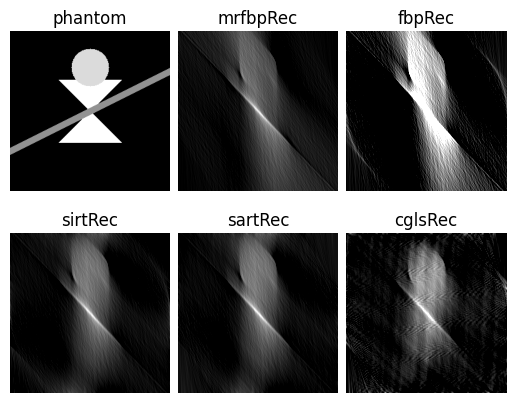

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.02196616306900978
Epoch 5002/10000, Loss: 0.02196957916021347
Epoch 5003/10000, Loss: 0.021971385926008224
Epoch 5004/10000, Loss: 0.0219712033867836
Epoch 5005/10000, Loss: 0.021969102323055267
Epoch 5006/10000, Loss: 0.021968049928545952
Epoch 5007/10000, Loss: 0.021965503692626953
Epoch 5008/10000, Loss: 0.021962877362966537
Epoch 5009/10000, Loss: 0.02196318656206131
Epoch 5010/10000, Loss: 0.021963587030768394
Epoch 5011/10000, Loss: 0.021964652463793755
Epoch 5012/10000, Loss: 0.021966351196169853
Epoch 5013/10000, Loss: 0.021969161927700043
Epoch 5014/10000, Loss: 0.021967843174934387
Epoch 5015/10000, Loss: 0.02196495234966278
Epoch 5016/10000, Loss: 0.021962668746709824
Epoch 5017/10000, Loss: 0.021962318569421768
Epoch 5018/10000, Loss: 0.021960733458399773
Epoch 5019/10000, Loss: 0.021959686651825905
Epoch 5020/10000, Loss: 0.021959437057375908
Epoch 5021/10000, Loss: 0.021959668025374413
Epoch 5022

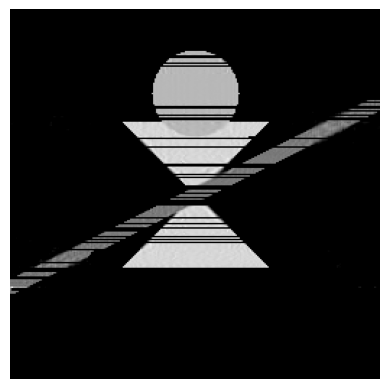

In [ ]:
phantom1_limited = grayscale_phantom()
sino1_limited = reconstruction(phantom1_limited, angles_start=0, angles_end=np.pi/4, size=256, noise=True)
CNNReC(phantom1_limited,sino1_limited)

<ipython-input-148-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-154-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


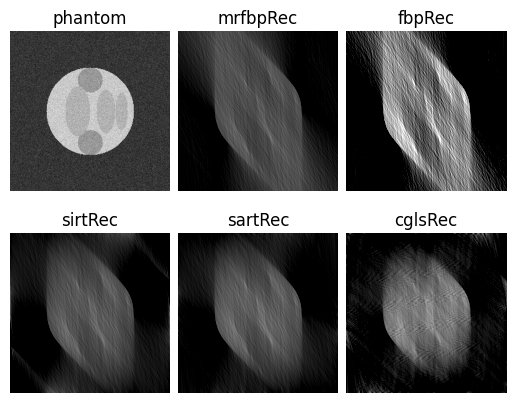

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.008513846434652805
Epoch 5002/10000, Loss: 0.008537840098142624
Epoch 5003/10000, Loss: 0.008527855388820171
Epoch 5004/10000, Loss: 0.008525105193257332
Epoch 5005/10000, Loss: 0.008503565564751625
Epoch 5006/10000, Loss: 0.008489610627293587
Epoch 5007/10000, Loss: 0.008490628562867641
Epoch 5008/10000, Loss: 0.008489922620356083
Epoch 5009/10000, Loss: 0.008497839793562889
Epoch 5010/10000, Loss: 0.008486272767186165
Epoch 5011/10000, Loss: 0.008475549519062042
Epoch 5012/10000, Loss: 0.008466281928122044
Epoch 5013/10000, Loss: 0.008473781868815422
Epoch 5014/10000, Loss: 0.008490140549838543
Epoch 5015/10000, Loss: 0.008507611230015755
Epoch 5016/10000, Loss: 0.008514259941875935
Epoch 5017/10000, Loss: 0.008500147610902786
Epoch 5018/10000, Loss: 0.00847912672907114
Epoch 5019/10000, Loss: 0.008458633907139301
Epoch 5020/10000, Loss: 0.008450029417872429
Epoch 5021/10000, Loss: 0.008452760986983776
Epoch

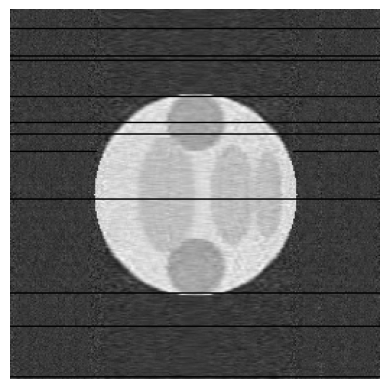

In [ ]:
phantom2_limited = brain_phantom()
sino2_limited = reconstruction(phantom2_limited, angles_start=0, angles_end=np.pi/4, size=256, noise=True)
CNNReC(phantom2_limited,sino2_limited)

<ipython-input-148-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-154-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


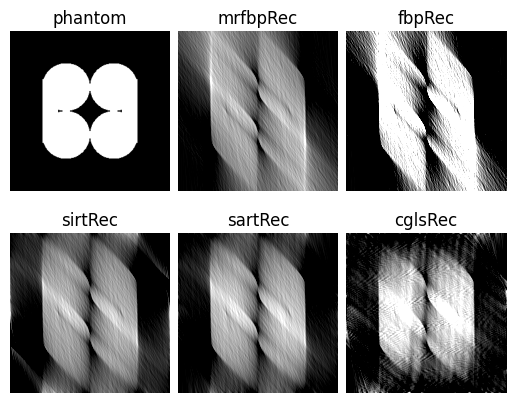

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.05470947176218033
Epoch 5002/10000, Loss: 0.05470801144838333
Epoch 5003/10000, Loss: 0.05470658838748932
Epoch 5004/10000, Loss: 0.05470583960413933
Epoch 5005/10000, Loss: 0.05470500513911247
Epoch 5006/10000, Loss: 0.054704681038856506
Epoch 5007/10000, Loss: 0.05470425635576248
Epoch 5008/10000, Loss: 0.05470435321331024
Epoch 5009/10000, Loss: 0.0547044612467289
Epoch 5010/10000, Loss: 0.054705437272787094
Epoch 5011/10000, Loss: 0.05470670759677887
Epoch 5012/10000, Loss: 0.05471009761095047
Epoch 5013/10000, Loss: 0.05471227690577507
Epoch 5014/10000, Loss: 0.05471673235297203
Epoch 5015/10000, Loss: 0.054715897887945175
Epoch 5016/10000, Loss: 0.05471307411789894
Epoch 5017/10000, Loss: 0.05470675602555275
Epoch 5018/10000, Loss: 0.054703205823898315
Epoch 5019/10000, Loss: 0.05470306798815727
Epoch 5020/10000, Loss: 0.0547044612467289
Epoch 5021/10000, Loss: 0.05470879375934601
Epoch 5022/10000, Loss:

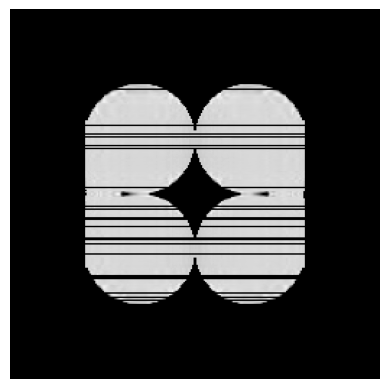

In [ ]:
phantom3_limited = binary_phantom()
sino3_limited = reconstruction(phantom3_limited, angles_start=0, angles_end=np.pi/4, size=256, noise=True)
CNNReC(phantom3_limited,sino3_limited)

<ipython-input-148-e569e7b7699e>:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = na.lstsq(A,b)
<ipython-input-154-f0b3313173ce>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


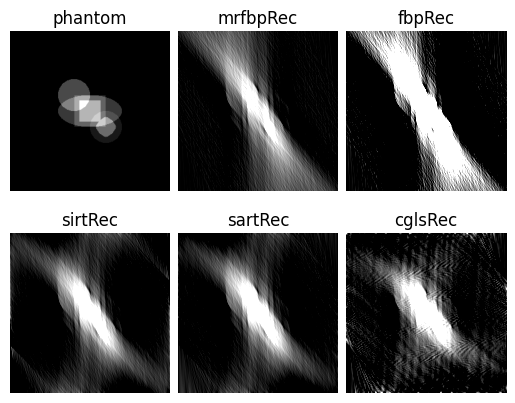

Streaming output truncated to the last 5000 lines.
Epoch 5001/10000, Loss: 0.002606719033792615
Epoch 5002/10000, Loss: 0.0026067171711474657
Epoch 5003/10000, Loss: 0.0026066601276397705
Epoch 5004/10000, Loss: 0.0026068524457514286
Epoch 5005/10000, Loss: 0.002606910653412342
Epoch 5006/10000, Loss: 0.0026074512861669064
Epoch 5007/10000, Loss: 0.002608087845146656
Epoch 5008/10000, Loss: 0.002609522081911564
Epoch 5009/10000, Loss: 0.002610541181638837
Epoch 5010/10000, Loss: 0.002611760515719652
Epoch 5011/10000, Loss: 0.0026121200062334538
Epoch 5012/10000, Loss: 0.002612310228869319
Epoch 5013/10000, Loss: 0.0026113283820450306
Epoch 5014/10000, Loss: 0.0026101660914719105
Epoch 5015/10000, Loss: 0.0026085595600306988
Epoch 5016/10000, Loss: 0.002607388189062476
Epoch 5017/10000, Loss: 0.0026066505815833807
Epoch 5018/10000, Loss: 0.002606405643746257
Epoch 5019/10000, Loss: 0.0026067981962114573
Epoch 5020/10000, Loss: 0.0026074654888361692
Epoch 5021/10000, Loss: 0.002608849667

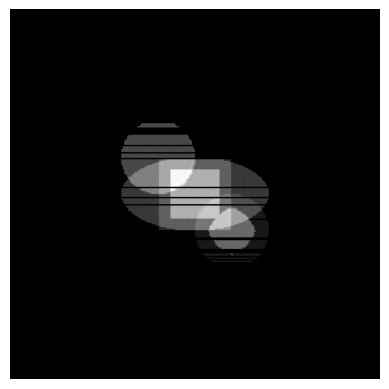

In [ ]:
phantom4_limited = blurry_phantom()
sino4_limited = reconstruction(phantom4_limited, angles_start=0, angles_end=np.pi/4, size=256, noise=True)
CNNReC(phantom4_limited,sino4_limited)